In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.api as sm
import seaborn as sns 
import statsmodels

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [3]:
df = pd.read_csv(r'Bond-VN.csv', index_col= 0,parse_dates=True)
df = df[['GGVF5Y','GGVF1Y','GGVF3Y','CPI','FER','Baserate','FIR','Stockreturn','Fiscal','Pubdebt','CurrentAcc']]


In [4]:
nobs = int(len(df)*0.2)
df_train, df_test = df[0:-nobs], df[-nobs:]

In [5]:
df.describe()

,GGVF5Y,GGVF1Y,GGVF3Y,CPI,FER,Baserate,FIR,Stockreturn,Fiscal,Pubdebt,CurrentAcc
count,162.000000,162.000000,162.000000,162.000000,1.620000e+02,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,0.080725,0.071499,0.076911,0.601198,3.113248e+10,8.885802,1.479954,0.764756,-2.879439,50.436752,-0.392593
std,0.033168,0.036271,0.034570,0.793960,1.633594e+10,1.085656,1.826785,8.797782,1.856116,6.870214,5.182574
min,0.020000,0.015500,0.018380,-0.756000,1.246660e+10,7.000000,0.310000,-24.009196,-5.027260,38.406899,-11.000000
25%,0.054277,0.043233,0.049960,0.131250,1.644710e+10,8.500000,0.375000,-3.245701,-4.260530,45.166601,-3.800000
50%,0.080000,0.067000,0.076030,0.404500,2.589349e+10,9.000000,0.500000,0.774177,-3.481840,51.674497,2.100000
75%,0.101268,0.092365,0.097433,0.831250,3.652729e+10,9.000000,2.000000,4.193213,-0.897920,57.097769,2.900000
max,0.203330,0.211670,0.206670,3.912000,6.881210e+10,14.000000,9.000000,38.517100,1.224610,59.662135,6.000000


# Linear Regression (OLS)

In [6]:
y_train = df_train.GGVF1Y
x_train = df_train[['GGVF5Y','CPI','FER','Baserate','FIR','Fiscal','CurrentAcc']]

y_test = df_test.GGVF1Y
x_test = df_test[['GGVF5Y','CPI','FER','Baserate','FIR','Fiscal','CurrentAcc']]

index_test = y_test.index

In [7]:
x_train,y_train = np.array(x_train), np.array(y_train)
# x_train = sm.add_constant(x_train)


In [8]:
x_test, y_test = np.array(x_test), np.array(y_test)
# x_test = sm.add_constant(x_test)

In [9]:
linear_regression_model = sm.OLS(y_train,x_train).fit()
print(linear_regression_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              4721.
Date:                Tue, 15 Mar 2022   Prob (F-statistic):                   3.01e-146
Time:                        16:12:53   Log-Likelihood:                          495.43
No. Observations:                 130   AIC:                                     -976.9
Df Residuals:                     123   BIC:                                     -956.8
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

***=> CPI, Oilrate, Stockreturn, Fiscal và CurrentAcc không có ý nghĩa thống kê. Tuy nhiên ta không thể loại bỏ các biến này được. Ta cần kiểm tra sự phụ thuộc của chúng vào các biến độc lập khác.***

# Đa cộng tuyến

In [10]:
corr = df[['GGVF5Y','CPI','FER','Baserate','FIR','Fiscal','CurrentAcc']].corr()
print('Pearson correlation coefficient matrix of each variables:\n', corr)

Pearson correlation coefficient matrix of each variables:
               GGVF5Y       CPI       FER  Baserate       FIR    Fiscal  \
GGVF5Y      1.000000  0.404803 -0.771573  0.320622 -0.000442  0.554195   
CPI         0.404803  1.000000 -0.284340  0.089155  0.208437  0.434922   
FER        -0.771573 -0.284340  1.000000  0.164828  0.035706 -0.470086   
Baserate    0.320622  0.089155  0.164828  1.000000  0.123343  0.241336   
FIR        -0.000442  0.208437  0.035706  0.123343  1.000000  0.593817   
Fiscal      0.554195  0.434922 -0.470086  0.241336  0.593817  1.000000   
CurrentAcc -0.438765 -0.363015  0.410349 -0.051126 -0.520684 -0.622307   

            CurrentAcc  
GGVF5Y       -0.438765  
CPI          -0.363015  
FER           0.410349  
Baserate     -0.051126  
FIR          -0.520684  
Fiscal       -0.622307  
CurrentAcc    1.000000  


<ipython-input-11-65927551eb8b>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


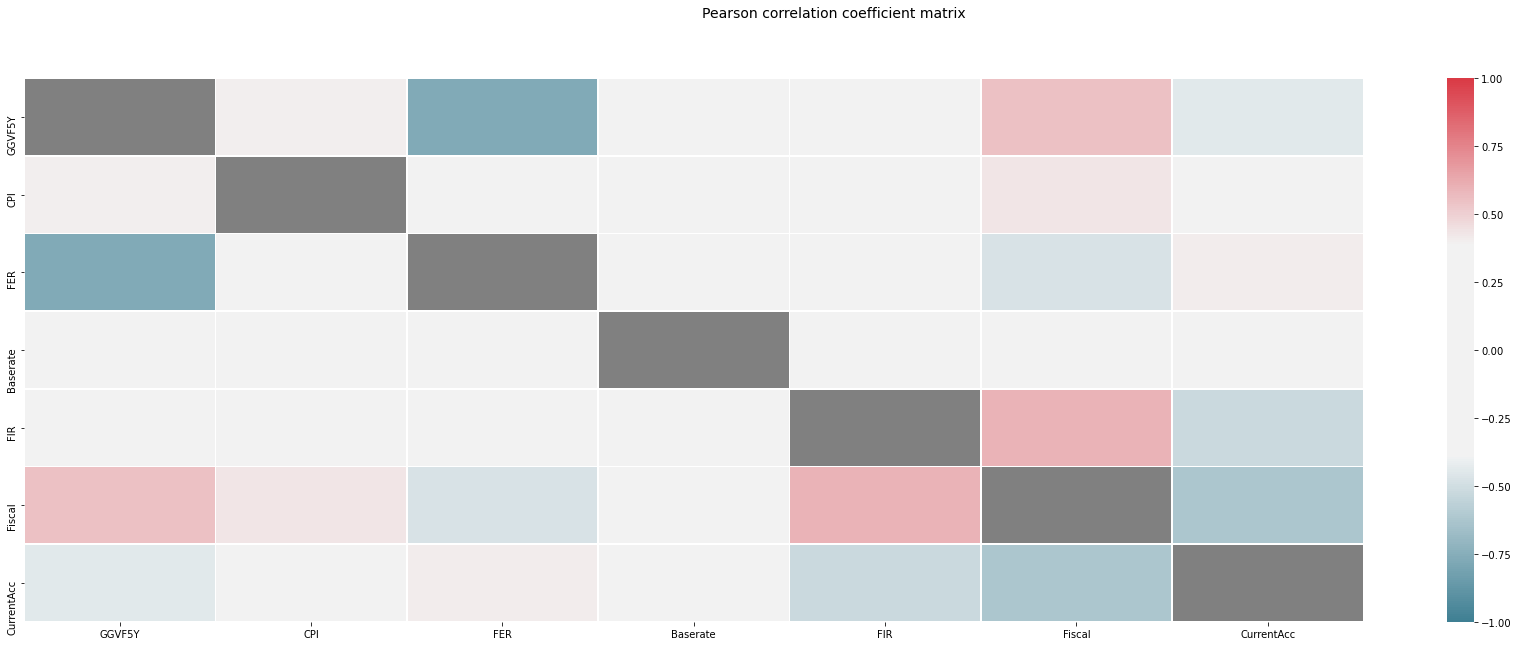

In [11]:
# Generate a mask for the diagonal cell
mask = np.zeros_like(corr, dtype=np.bool)
np.fill_diagonal(mask, val=True)

# Initialize matplotlib figure
fig, ax = plt.subplots(figsize=(30, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)
cmap.set_bad('grey')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)
fig.suptitle('Pearson correlation coefficient matrix', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)


# Tự tương quan

In [12]:
from statsmodels.stats.stattools import durbin_watson

durbinWatson = durbin_watson(linear_regression_model.resid)

print('Durbin-Watson:', durbinWatson,'\n')
if durbinWatson < 1.5:
    print('Signs of positive autocorrelation', '\n')
    print('Assumption not satisfied')
elif durbinWatson > 2.5:
    print('Signs of negative autocorrelation', '\n')
    print('Assumption not satisfied')
else:
    print('Little to no autocorrelation', '\n')
    print('Assumption satisfied')

Durbin-Watson: 0.5702088260339926 

Signs of positive autocorrelation 

Assumption not satisfied


# Kiểm định Ramsey

In [13]:
# Kiểm định Ramsey
ramsey_test = statsmodels.stats.diagnostic.linear_reset(linear_regression_model, power=2, test_type='fitted')
print(f'P-value of Ramsey test: {ramsey_test.pvalue}')

if ramsey_test.pvalue < 0.1:
    print('Vậy với α = 0,1 và P-value < 0.1, mô hình gốc không có sự thiếu biến.')
else:
    print('Vậy với α = 0,1 và P-value > 0.1, mô hình gốc có sự thiếu biến.')

P-value of Ramsey test: 5.01761032168641e-06
Vậy với α = 0,1 và P-value < 0.1, mô hình gốc không có sự thiếu biến.


***Trực quan hóa***

In [14]:
prediction_result = linear_regression_model.predict(x_test)

In [15]:
table_1 = pd.DataFrame({'Real': y_test,
                        'Prediction':prediction_result},index= index_test)

In [16]:
table_1.head(10)


,Real,Prediction
Time,,
2017-05-01,0.03800,0.040135
2017-06-01,0.03700,0.037977
2017-07-01,0.03360,0.034720
2017-08-01,0.04110,0.036496
2017-09-01,0.04000,0.033879
2017-10-01,0.03840,0.033070
2017-11-01,0.04054,0.033831
2017-12-01,0.03640,0.030568
2018-01-01,0.02902,0.020282


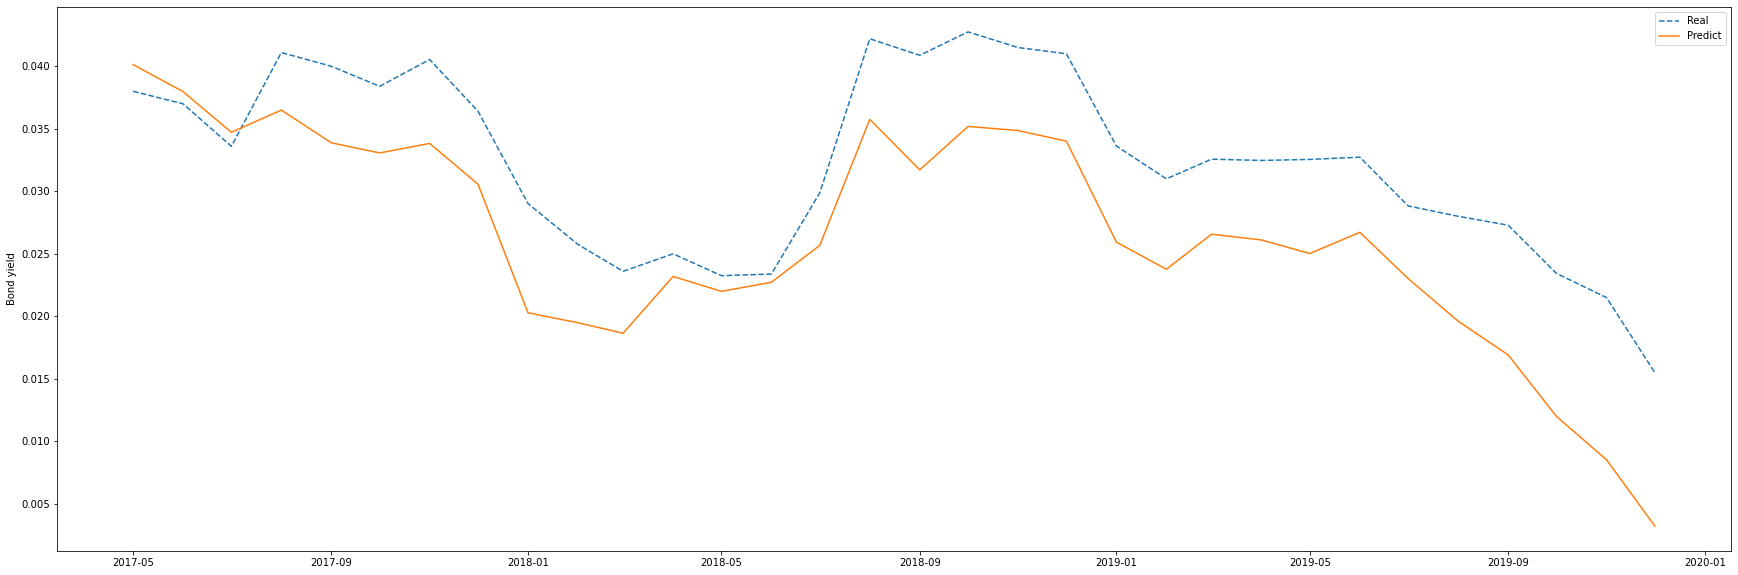

In [17]:
plt.figure(figsize=(30,10))

plt.plot(table_1.Real,'--')
plt.plot(table_1.Prediction)

plt.legend(['Real','Predict'])

plt.ylabel('Bond yield')
plt.show()

In [18]:
rmse = np.sqrt(mean_squared_error(table_1.Real, table_1.Prediction))
mae = mean_absolute_error(table_1.Real, table_1.Prediction)
mape = (mean_absolute_percentage_error(table_1.Real, table_1.Prediction))*100

In [19]:
print(f'RMSE = {rmse}')
print(f'MAE  = {mae}')
print(f'MAPE = {round(mape,2)}%')


RMSE = 0.0069682585869105815
MAE  = 0.006236972862147014
MAPE = 21.25%
